# 0. Imports

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

import datetime

import matplotlib.pyplot as plt
import optuna
import torch
import torch.optim as optim
from optuna.trial import TrialState
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from tqdm import tqdm

torch.manual_seed(41)

# 1. 1-D CNN Setup

## 1.1. Dataset and DataLoader Read In

In [2]:
feature_names = pd.read_csv(
    "../data/fine_dust_dataset.csv", nrows=1
).columns.tolist()

In [3]:
trainloader = torch.load("../models/trainloader.pth")
validloader = torch.load("../models/validloader.pth")
testloader = torch.load("../models/testloader.pth")

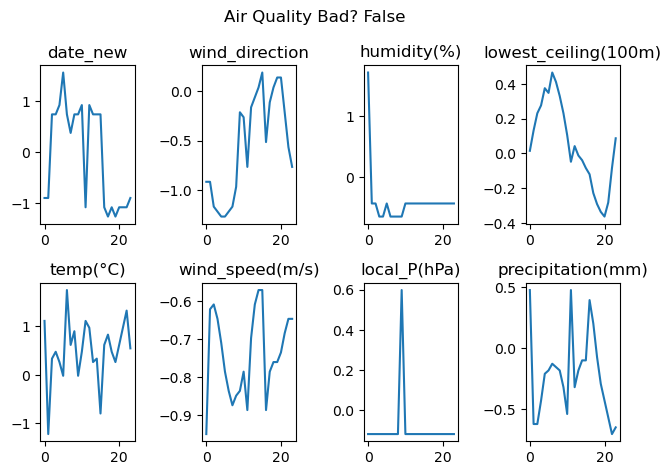

In [4]:
# Sample Check

weather, label = next(iter(trainloader))
i = np.random.randint(0, 28)
fig, axs = plt.subplots(nrows=2, ncols=4)
r = 0
c = 0
for j in range(8):
    axs[r, c].plot(weather[i, j, :])
    axs[r, c].set_title(f"{feature_names[j]}")
    if c < 3:
        c += 1
    else:
        r += 1
        c = 0
fig.suptitle(f"Air Quality Bad? {bool(label[i])}")
plt.tight_layout()
plt.show();

## 1.2. Preparation of 1-D CNN

In [5]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(
        self,
        trial,
        num_filter_1,
        num_filter_2,
        num_filter_3,
        num_fc,
        drop_out_rate_1,
        drop_out_rate_2,
        drop_out_rate_3,
    ):
        """
        Parameters:
            - trial (optuna.trial._trial.Trial): Optuna trial
            - num_filters (int):                 Number of filters of conv layers
            - num_fc (int):                      Number of neurons of FC layers
            - drop_out_rate (float):             Dropout ratio
        """
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(8, num_filter_1, kernel_size=3, padding=1),  # num_filter_1, 24
            nn.ReLU(),
            nn.MaxPool1d(2),  # num_filter_1, 12
            nn.Dropout(drop_out_rate_1),
            nn.Conv1d(
                num_filter_1, num_filter_2, kernel_size=3, padding=1
            ),  # num_filter_2, 12
            nn.ReLU(),
            nn.MaxPool1d(2),  # num_filter_2,  6
            nn.Dropout(drop_out_rate_2),
            nn.Conv1d(
                num_filter_2, num_filter_3, kernel_size=3, padding=1
            ),  # num_filter_3, 6
            nn.ReLU(),
            nn.MaxPool1d(2),  # num_filter_3, 3
            nn.Dropout(drop_out_rate_3),
            nn.Flatten(),  # num_filter_3 x 3
            nn.Linear(num_filter_3 * 3, num_fc),  # num_fc
            nn.ReLU(),
            nn.Linear(num_fc, 1),
        )

    def forward(self, x):
        logits = self.main(x)
        return logits

In [6]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        torch.nn.init.xavier_uniform_(m.weight.data)

## 1.3. Preparation of Functions for Optuna Hyperparameter Tuning

In [7]:
def train(network, optimizer, trainloader, criterion):
    """Trains the model.

    Parameters:
        - network (__main__.Net):              The CNN
        - optimizer (torch.optim.<optimizer>): The optimizer for the CNN
    """
    network.train()  # Set the module in training mode 
    for batch_i, (X, y) in enumerate(trainloader):  # For each batch

        optimizer.zero_grad()  # Clear gradients
        y_hat = network(X)  # Forward propagation
        loss = criterion(
            y_hat, y.unsqueeze(1)
        )  # Compute loss (negative log likelihood: −log(y))
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights

In [8]:
def test(network, validloader, criterion):
    """Tests the model.

    Parameters:
        - network (__main__.Net): The CNN

    Returns:
        - accuracy_test (torch.Tensor): The test accuracy
    """
    network.eval()  # Set the module in evaluation mode 

    valid_batch_acc = 0

    with torch.no_grad():  # Disable gradient calculation 
        for batch_i, (X, y) in enumerate(validloader):  # For each batch

            y_hat = network(X)  # Forward propagation
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            valid_batch_acc += (
                (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
            )

    valid_accuracy = valid_batch_acc / len(validloader)  # accuracy

    return valid_accuracy

In [9]:
def objective(trial):
    """Objective function to be optimized by Optuna.

    Hyperparameters chosen to be optimized: optimizer, learning rate,
    number of filters, number of neurons in fully connected layer, and dropout values,

    Inputs:
        - trial (optuna.trial._trial.Trial): Optuna trial
    Returns:
        - accuracy(torch.Tensor): The test accuracy. Parameter to be maximized.
    """

    # Define range of values to be tested for the hyperparameters
    num_filter_1 = trial.suggest_int("num_filter_1", 4, 32, 4)
    num_filter_2 = trial.suggest_int("num_filter_2", 4, 32, 4)
    num_filter_3 = trial.suggest_int("num_filter_3", 4, 32, 4)
    num_fc = trial.suggest_int("num_fc", 2, 12, 2)
    drop_out_rate_1 = trial.suggest_float("drop_out_rate_1", 0.1, 0.35, step=0.05)
    drop_out_rate_2 = trial.suggest_float("drop_out_rate_2", 0.1, 0.35, step=0.05)
    drop_out_rate_3 = trial.suggest_float("drop_out_rate_3", 0.1, 0.35, step=0.05)

    # Generate the model
    model = ConvolutionalNeuralNetwork(
        trial,
        num_filter_1,
        num_filter_2,
        num_filter_3,
        num_fc,
        drop_out_rate_1,
        drop_out_rate_2,
        drop_out_rate_3,
    )  # .to(device)

    # Generate the optimizers
    optimizer_name = trial.suggest_categorical(
        "optimizer", ["Adam", "RMSprop", "SGD"]
    )  # Optimizers
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)  # Learning rates
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        train(model, optimizer, trainloader, criterion)  # Train the model
        accuracy = test(model, validloader, criterion)  # Evaluate the model

        # For pruning (stops trial early if not promising)
        trial.report(accuracy, epoch)
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

# 2. Hyperparameter Optimization Using Optuna

## 2.1. Hyperparameter Optimization

In [10]:
n_epochs = 100  # Number of training epochs
number_of_trials = 200  # Number of Optuna trials
criterion = nn.BCEWithLogitsLoss()

In [11]:
study = optuna.create_study(direction="maximize")

[I 2023-07-30 11:09:21,389] A new study created in memory with name: no-name-5d4cff2d-f87a-40a6-8d46-92242f680629


In [12]:
study.optimize(objective, n_trials=number_of_trials)

[I 2023-07-30 11:10:50,327] Trial 0 finished with value: 0.7770270258188248 and parameters: {'num_filter_1': 8, 'num_filter_2': 16, 'num_filter_3': 4, 'num_fc': 4, 'drop_out_rate_1': 0.25, 'drop_out_rate_2': 0.25, 'drop_out_rate_3': 0.25, 'optimizer': 'Adam', 'lr': 0.00027205697956488956}. Best is trial 0 with value: 0.7770270258188248.
[I 2023-07-30 11:12:01,204] Trial 1 finished with value: 0.760810808958234 and parameters: {'num_filter_1': 12, 'num_filter_2': 32, 'num_filter_3': 28, 'num_fc': 4, 'drop_out_rate_1': 0.35, 'drop_out_rate_2': 0.35, 'drop_out_rate_3': 0.25, 'optimizer': 'RMSprop', 'lr': 2.6917883038381803e-05}. Best is trial 0 with value: 0.7770270258188248.
[I 2023-07-30 11:13:36,595] Trial 2 finished with value: 0.7891891836314588 and parameters: {'num_filter_1': 12, 'num_filter_2': 8, 'num_filter_3': 28, 'num_fc': 2, 'drop_out_rate_1': 0.35, 'drop_out_rate_2': 0.15000000000000002, 'drop_out_rate_3': 0.1, 'optimizer': 'RMSprop', 'lr': 0.00583825455437186}. Best is tria

## 2.2. Optimization Results

In [13]:
# Find number of pruned and completed trials
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

In [14]:
# Display the study statistics
print("\nStudy statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))


Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  153
  Number of complete trials:  47


In [15]:
trial = study.best_trial
print("Best trial:")
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  0.8256756743869266
  Params: 
    num_filter_1: 24
    num_filter_2: 16
    num_filter_3: 24
    num_fc: 6
    drop_out_rate_1: 0.35
    drop_out_rate_2: 0.2
    drop_out_rate_3: 0.1
    optimizer: RMSprop
    lr: 0.0038095116489375554


In [16]:
# Save results to csv file
hyper_df = study.trials_dataframe().drop(
    ["datetime_start", "datetime_complete", "duration"], axis=1
)  # Exclude columns
hyper_df = hyper_df.loc[
    hyper_df["state"] == "COMPLETE"
]  # Keep only results that did not prune
hyper_df = hyper_df.drop("state", axis=1)  # Exclude state column
hyper_df = hyper_df.sort_values("value")  # Sort based on accuracy
hyper_df.to_csv("../data/optuna_results_1d.csv", index=False)  # Save to csv file

In [17]:
# Display results in a dataframe
print("\nOverall Results (ordered by accuracy):\n")
hyper_df


Overall Results (ordered by accuracy):



,number,value,params_drop_out_rate_1,params_drop_out_rate_2,params_drop_out_rate_3,params_lr,params_num_fc,params_num_filter_1,params_num_filter_2,params_num_filter_3,params_optimizer
3,3,0.447297,0.25,0.10,0.10,0.000045,4,24,8,28,SGD
1,1,0.760811,0.35,0.35,0.25,0.000027,4,12,32,28,RMSprop
4,4,0.766216,0.15,0.30,0.35,0.000628,12,16,12,4,Adam
129,129,0.770270,0.20,0.30,0.10,0.003561,6,32,28,16,RMSprop
107,107,0.777027,0.20,0.20,0.10,0.002461,6,32,24,12,RMSprop
0,0,0.777027,0.25,0.25,0.25,0.000272,4,8,16,4,Adam
153,153,0.781081,0.25,0.20,0.10,0.003460,4,28,28,12,RMSprop
72,72,0.782432,0.25,0.20,0.10,0.001672,10,24,24,28,Adam
144,144,0.783784,0.15,0.25,0.10,0.003844,10,32,24,8,Adam
79,79,0.783784,0.20,0.30,0.10,0.005530,8,16,16,12,RMSprop


In [18]:
# Find the most important hyperparameters
most_important_parameters = optuna.importance.get_param_importances(study, target=None)

In [19]:
# Display the most important hyperparameters
print("\nMost important hyperparameters:")
for key, value in most_important_parameters.items():
    print("  {}:{}{:.2f}%".format(key, (15 - len(key)) * " ", value * 100))


Most important hyperparameters:
  drop_out_rate_2:38.28%
  optimizer:      34.95%
  drop_out_rate_3:10.20%
  drop_out_rate_1:5.53%
  lr:             5.22%
  num_filter_2:   2.23%
  num_fc:         1.61%
  num_filter_3:   1.38%
  num_filter_1:   0.60%


# 3. 1-D CNN Model Training

## 3.1. Model Setup with Optimized Hyperparameters

In [20]:
trial.params

{'num_filter_1': 24,
 'num_filter_2': 16,
 'num_filter_3': 24,
 'num_fc': 6,
 'drop_out_rate_1': 0.35,
 'drop_out_rate_2': 0.2,
 'drop_out_rate_3': 0.1,
 'optimizer': 'RMSprop',
 'lr': 0.0038095116489375554}

In [21]:
model = ConvolutionalNeuralNetwork(
    trial,
    num_filter_1=trial.params["num_filter_1"],
    num_filter_2=trial.params["num_filter_2"],
    num_filter_3=trial.params["num_filter_3"],
    num_fc=trial.params["num_fc"],
    drop_out_rate_1=trial.params["drop_out_rate_1"],
    drop_out_rate_2=trial.params["drop_out_rate_2"],
    drop_out_rate_3=trial.params["drop_out_rate_3"],
)

In [22]:
def trainer(
    model,
    criterion,
    optimizer,
    trainloader,
    validloader,
    epochs=5,
    patience=5,
    verbose=True,
):
    """Simple training wrapper for PyTorch network."""

    train_loss, valid_loss, train_accuracy, valid_accuracy = [], [], [], []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        valid_batch_loss = 0
        train_batch_acc = 0
        valid_batch_acc = 0

        # Training
        for X, y in trainloader:
            optimizer.zero_grad()  # Zero all the gradients w.r.t. parameters
            # X = X.to(device)
            # y = y.to(device)
            y_hat = model(X)  # forward pass to get output
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            loss = criterion(y_hat, y.unsqueeze(1))  # Calculate loss based on output
            loss.backward()  # Calculate gradients w.r.t. parameters
            optimizer.step()  # Update parameters
            train_batch_loss += loss.item()  # Add loss for this batch to running total
            train_batch_acc += (
                (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
            )
        train_loss.append(train_batch_loss / len(trainloader))
        train_accuracy.append(train_batch_acc / len(trainloader))  # accuracy

        # Validation
        model.eval()
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for X, y in validloader:
                # X = X.to(device)
                # y = y.to(device)
                y_hat = model(X)  # forward pass to get output
                y_hat_labels = torch.sigmoid(y_hat) > 0.5
                loss = criterion(y_hat, y.unsqueeze(1))
                valid_batch_loss += loss.item()
                valid_batch_acc += (
                    (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
                )
        valid_loss.append(valid_batch_loss / len(validloader))
        valid_accuracy.append(valid_batch_acc / len(validloader))  # accuracy

        model.train()

        # Print progress
        if verbose:
            if (epoch + 1) % 100 == 0:
                print(
                    f"Epoch {epoch + 1}:",
                    f"Train Loss: {train_loss[-1]:.3f}.",
                    f"Valid Loss: {valid_loss[-1]:.3f}.",
                    f"Train Accuracy: {train_accuracy[-1]:.2f}."
                    f"Valid Accuracy: {valid_accuracy[-1]:.2f}.",
                )

        # Early stopping
        if epoch > 0 and valid_loss[-1] > valid_loss[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if consec_increases == patience:
            print(
                f"Stopped early at epoch {epoch + 1} - val loss increased for {consec_increases} consecutive epochs!"
            )
            break

    print("\nTraining ended.")

    loss_fig = pd.DataFrame(
        {"train_loss": train_loss, "valid_loss": valid_loss}
    ).plot.line()
    loss_fig.set_xlabel("Epoch")
    loss_fig.set_ylabel("Loss")

    accur_fig = pd.DataFrame(
        {"train_accuracy": train_accuracy, "valid_accuracy": valid_accuracy}
    ).plot.line()
    accur_fig.set_xlabel("Epoch")
    accur_fig.set_ylabel("Accuracy");

In [23]:
model.apply(weights_init)

ConvolutionalNeuralNetwork(
  (main): Sequential(
    (0): Conv1d(8, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.35, inplace=False)
    (4): Conv1d(24, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv1d(16, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): ReLU()
    (10): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.1, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=72, out_features=6, bias=True)
    (14): ReLU()
    (15): Linear(in_features=6, out_features=1, bias=True)
  )
)

## 3.2. Model Training

In [24]:
criterion = nn.BCEWithLogitsLoss()
optimizer = getattr(optim, trial.params["optimizer"])(
    model.parameters(), lr=trial.params["lr"]
)

Epoch 100: Train Loss: 0.349. Valid Loss: 0.418. Train Accuracy: 0.84.Valid Accuracy: 0.81.
Epoch 200: Train Loss: 0.337. Valid Loss: 0.423. Train Accuracy: 0.85.Valid Accuracy: 0.80.
Epoch 300: Train Loss: 0.318. Valid Loss: 0.420. Train Accuracy: 0.86.Valid Accuracy: 0.82.
Epoch 400: Train Loss: 0.295. Valid Loss: 0.479. Train Accuracy: 0.87.Valid Accuracy: 0.80.
Epoch 500: Train Loss: 0.310. Valid Loss: 0.453. Train Accuracy: 0.87.Valid Accuracy: 0.80.
Epoch 600: Train Loss: 0.303. Valid Loss: 0.433. Train Accuracy: 0.86.Valid Accuracy: 0.80.
Stopped early at epoch 670 - val loss increased for 5 consecutive epochs!

Training ended.


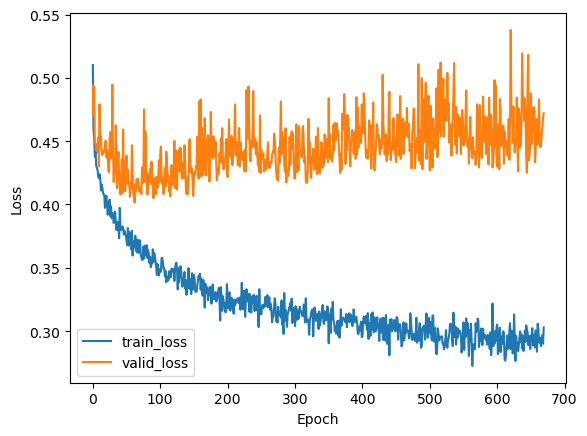

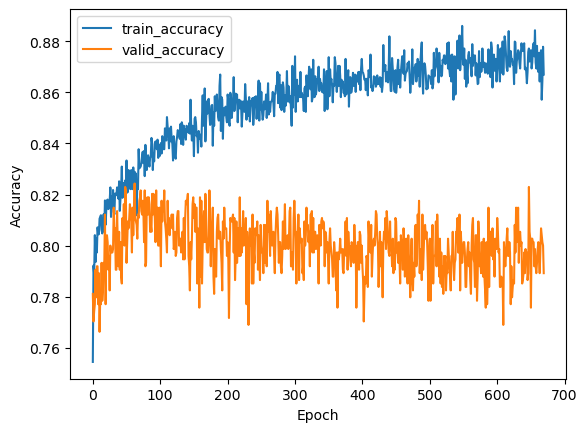

In [25]:
trainer(
    model,
    criterion,
    optimizer,
    trainloader,
    validloader,
    epochs=2001,
    patience=5,
    verbose=True,
)

## 3.3. Check on Accuracy on Test Set

In [26]:
test_accuracy = []
test_batch_acc = 0

model.eval()
with torch.no_grad():
    for X, y in testloader:
        y_hat = model(X)  # forward pass to get output
        y_hat_labels = torch.sigmoid(y_hat) > 0.5
        test_batch_acc += (
            (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        )

test_accuracy.append(test_batch_acc / len(testloader))  # accuracy

In [27]:
test_accuracy

[0.834703191706579]

## 3.4. Prediction

Prbability of Bad Air Quality: 0.431


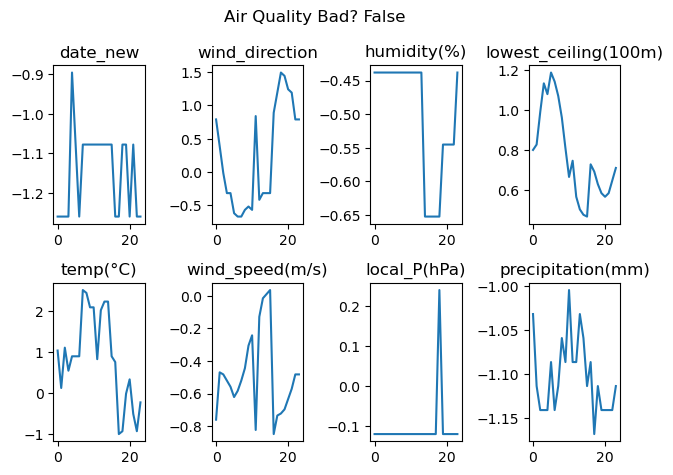

In [28]:
model.eval()
with torch.no_grad():
    wea, lab = next(iter(testloader))
    y_prob = torch.sigmoid(model(wea)[0])
    y_class = int(y_prob > 0.5)
    print(f"Prbability of Bad Air Quality: {y_prob.item():.3g}")
    fig, axs = plt.subplots(nrows=2, ncols=4)
    r = 0
    c = 0
    for j in range(8):
        axs[r, c].plot(weather[0, j, :])
        axs[r, c].set_title(f"{feature_names[j]}")
        if c < 3:
            c += 1
        else:
            r += 1
            c = 0
    fig.suptitle(f"Air Quality Bad? {bool(lab[0])}")
    plt.tight_layout()
    plt.show();

## 3.5. Model Save

In [29]:
torch.save(model, "../models/1d_cnn_model.pt")